# Image classification using CNNs in Keras 

The project is from a dataset from Kaggle. 
Link to the Kaggle project site: https://www.kaggle.com/c/plant-seedlings-classification/data 

Context: 
Can you differentiate a weed from a crop seedling?  
The ability to do so effectively can mean better crop yields and better stewardship of the environment.  
The Aarhus University Signal Processing group, in collaboration with University of Southern Denmark, has 
recently released a dataset containing images of unique plants belonging to 12 species at several growth stages

Steps and tasks: 
1. Import the libraries, load dataset, print shape of data, visualize the images in dataset. (5 Marks) 
2. Data Pre-processing: (15 Marks) a. Normalization. b. Gaussian Blurring. c. Visualize data after pre-processing. 
3. Make data compatible: (10 Marks) a. Split the dataset into training, testing, and validation set.  (Hint: First split train images and train labels into training and testing set with test_size = 0.3. Then further split test data into test and validation set with test_size = 0.5) [Read the note at the end of the problem statement for the reason behind using the train images for using for training and testing set.] b. Reshape data into shapes compatible with Keras models. c. Convert labels from digits to one hot vectors. d. Print the label for y_train[0]. 
4. Building CNN: (15 Marks) 
    a. Define layers. 
    b. Set optimizer and loss function. (Use Adam optimizer and categorical crossentropy.) 
5. Fit and evaluate model and print confusion matrix. (10 Marks) 
6. Visualize predictions for x_test[2], x_test[3], x_test[33], x_test[36], x_test[59]. (5 Marks) 
Note: Download the train images from the Kaggle dataset, don’t download the test images.  As the test dataset is not labeled, so you won’t be able to calculate the accuracy score. So use train images and train labels only to split further into training and testing set during your model building. 

In [1]:
# Import necessary libraries.
import cv2
import math
import numpy as np
import pandas as pd
from glob import glob
from matplotlib import pyplot as plt
%matplotlib inline
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalMaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


# Loading & Visualization

In [3]:
# Set the path to the dataset folder. (The dataset contains image folder: "train")
train_path = "C:\\Users\PAU\Documents\Python Scripts\Project_07\train.zip"

In [4]:
# Make different folders for train and test data in the current directory of Google Colab notebook. (using mkdir)
!mkdir temp_train

A subdirectory or file temp_train already exists.


In [5]:
# Extract the files from dataset to temp_train and temp_test folders (as the dataset is a zip file.)
from zipfile import ZipFile
with ZipFile(train_path, 'r') as zip:
  zip.extractall('./temp_train')

OSError: [Errno 22] Invalid argument: 'C:\\Users\\PAU\\Documents\\Python Scripts\\Project_07\train.zip'

In [6]:
path = "./temp_train/*/*.png"                              # The path to all images in training set. (* means include all folders and files.)
files = glob(path)

trainImg = []                                              # Initialize empty list to store the image data as numbers.
trainLabel = []                                            # Initialize empty list to store the labels of images
j = 1
num = len(files)

# Obtain images and resizing, obtain labels
for img in files:
    '''
    Append the image data to trainImg list.
    Append the labels to trainLabel list.
    '''
    print(str(j) + "/" + str(num), end="\r")
    trainImg.append(cv2.resize(cv2.imread(img), (128, 128)))  # Get image (with resizing to 128x128)
    trainLabel.append(img.split('/')[-2])  # Get image label (folder name contains the class to which the image belong)
    j += 1

trainImg = np.asarray(trainImg)  # Train images set
trainLabel = pd.DataFrame(trainLabel)  # Train labels set

In [7]:
print(trainImg.shape)
print(trainLabel.shape)

(4750, 128, 128, 3)
(4750, 1)


In [8]:
#save the path into variable to use it easily each time
seed_train = "temp_train"

In [9]:
images = []
classes=[]
missing=0
for class_folder_name in os.listdir(seed_train):
    class_folder_path = os.path.join(seed_train, class_folder_name)
    class_label = class_folder_name
    
    for image_path in glob(os.path.join(class_folder_path, "*.png")):
        image_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if image_bgr is None: # if the file contains any missig value ignore it
          missing += 1
          continue
        images.append(image_bgr)
        
        classes.append(class_label)

In [10]:
#resizing all images

def resize_images(img):

  img = np.array(img).astype(np.uint8)
  #print(img.dtype)
  res = cv2.resize(img,(256,256), interpolation = cv2.INTER_CUBIC)
  return res
#resized=[]
#for image in images:
#  ressized= resize_images(images[image])

In [11]:
#save resized images into images.
images = [resize_images(img) for img in images]

In [12]:
images[0].shape

(256, 256, 3)

In [13]:
#see number of images in each class
images = np.array(images)
classes = np.array(classes)
print("images shape: ", images.shape)
print("classes shape: ", classes.shape)
#for key,value in images_per_class.items():
   # print("number of {0} images is  -> {1}".format(key, len(value)))
  
for label in set(classes):
    
  print("number of {} images is  -> {}".format(
        label, 
        len(images[classes == label])))

images shape:  (4750, 256, 256, 3)
classes shape:  (4750,)
number of Maize images is  -> 221
number of Common wheat images is  -> 221
number of Scentless Mayweed images is  -> 516
number of Charlock images is  -> 390
number of Shepherds Purse images is  -> 231
number of Common Chickweed images is  -> 611
number of Small-flowered Cranesbill images is  -> 496
number of Black-grass images is  -> 263
number of Loose Silky-bent images is  -> 654
number of Cleavers images is  -> 287
number of Sugar beet images is  -> 385
number of Fat Hen images is  -> 475


Text(0.5, 0.98, 'Categorical Plotting')

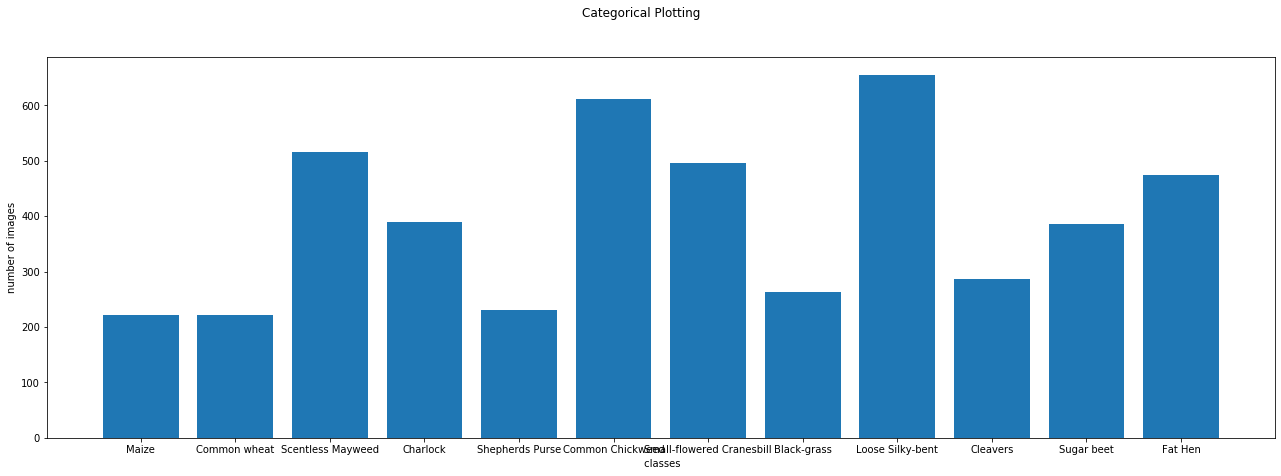

In [14]:
#plotting the distribution of images

values =[]
labels=[]
for label in set(classes):
  values.append(len(images[classes == label]))
  labels.append(label)

fig, ax = plt.subplots(figsize=(22,7))
ax.bar(labels, values)
ax.set_xlabel(" classes")
ax.set_ylabel("number of images")
#axs[1].scatter(label, )
  #axs[2].plot(names, values)
fig.suptitle('Categorical Plotting')

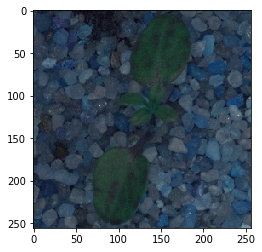

In [15]:
#image after resize 

plt.imshow(images[666])

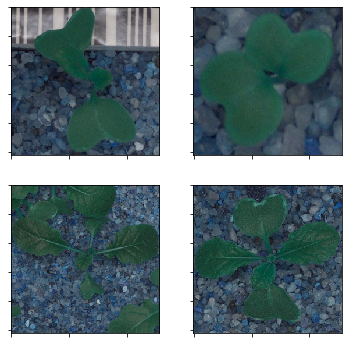

In [16]:
def plot_for_class(label):
    nb_rows = 2
    nb_cols = 2
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(6, 6))
    class_images =images[classes== label]
    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].xaxis.set_ticklabels([])
            axs[i, j].yaxis.set_ticklabels([])
            axs[i, j].imshow(class_images[n])
            n += 1 
plot_for_class("Charlock")

In [17]:
#train one image

img = cv2.imread("temp_train/Charlock/3e2cf6dc3.png")

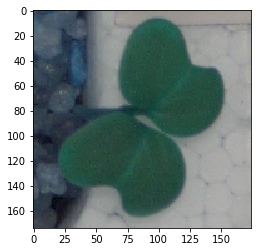

In [18]:
plt.imshow(img)

# Data Pre-processing

In [19]:
#convert image from RGB to HSV 
#Apply closing operation (one of morphological operation)
#Apply segmentation 
#Apply sharpening 

def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

In [20]:
#combine all functions / operations 

def segment(img):

  #image_mask = create_mask_for_plant(img)
  image_segmented = segment_plant(img)
  image_sharpen = sharpen_image(image_segmented)
  return image_sharpen

In [21]:
#iterate on all images

for indx, image in enumerate(images):
  try:
     images[indx] = segment(image)
      
  except:
    print(indx)
    continue

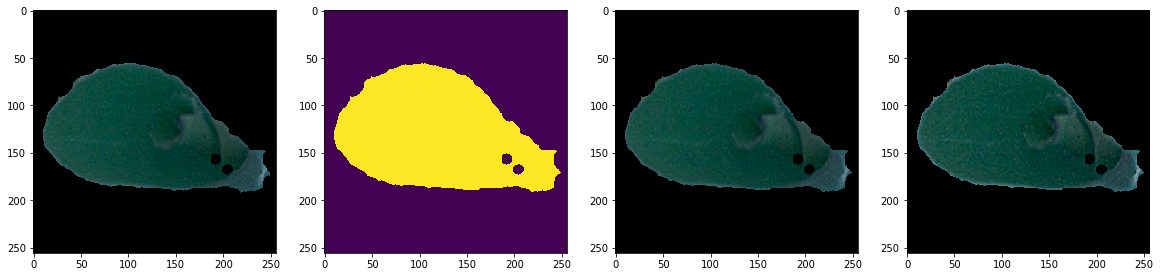

In [22]:
#plot sample image to see the difference

image = images[classes == "Maize"][60]

image_mask = create_mask_for_plant(image)
image_segmented = segment_plant(image)
image_sharpen = sharpen_image(image_segmented)

fig, axs = plt.subplots(1, 4, figsize=(20, 20))
axs[0].imshow(image)
axs[1].imshow(image_mask)
axs[2].imshow(image_segmented)
axs[3].imshow(image_sharpen)

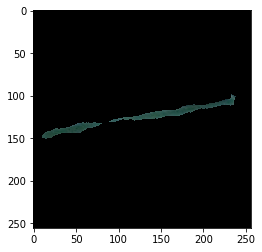

In [23]:
plt.imshow(images[0])

In [24]:
images.shape

(4750, 256, 256, 3)

# Make Data Compatible

In [25]:
#apply label encoding

from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y = enc.fit_transform(classes)

In [26]:
y[0]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [27]:
#split data in train and test set

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, y, test_size=0.3, random_state=50)

In [28]:
X_train.shape

(3325, 256, 256, 3)

In [29]:
#create validation set

random_seed = 2
from sklearn.model_selection import train_test_split
X_test, X_val, y_test, Y_val = train_test_split(X_test,y_test, test_size = 0.5, random_state=random_seed)

In [30]:
print(X_test.shape)
print(X_val.shape)

(712, 256, 256, 3)
(713, 256, 256, 3)


# Build CNN Model

In [31]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalMaxPooling2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

# Set the CNN model 

batch_size = None

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', batch_input_shape = (batch_size,256, 256, 3)))


model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.4))



model.add(GlobalMaxPooling2D())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(12, activation = "softmax"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 32)      2432      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 32)      25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 64)       

In [32]:
#Optimize the model

opt = Adam(lr=0.001)

optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])

In [ ]:
#Fit and run the model

model.fit(X_train, y_train, epochs = 10, validation_data = (X_val,Y_val),batch_size = batch_size)

In [33]:
score = model.evaluate(X_test, y_test, verbose=0, batch_size = 38)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 10.518999895352996
Test accuracy: 0.07865168899297714


In [ ]:
X_test.shape

# Refining the Model

In [34]:
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 5
batch_size = 38

In [35]:
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [ ]:
X_train, X_test, y_train, y_test
history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/5


In [ ]:
score = model.evaluate(X_test, y_test, verbose=0, batch_size = None)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Evaluate the Model

In [ ]:
fig, ax = plt.subplots(2,1 , figsize=(22,7))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [31]:
import matplotlib.pyplot as plt
def plot_model(model):
    plots = [i for i in model.history.history.keys() if i.find('val_') == -1]
    plt.figure(figsize=(10,10))

    for i, p in enumerate(plots):
        plt.subplot(len(plots), 2, i + 1)
        plt.title(p)
        plt.plot(model.history.history[p], label=p)
        plt.plot(model.history.history['val_'+p], label='val_'+p)
        plt.legend()

    plt.show()
    
plot_model(model)

NameError: name 'model' is not defined

NameError: name 'model' is not defined

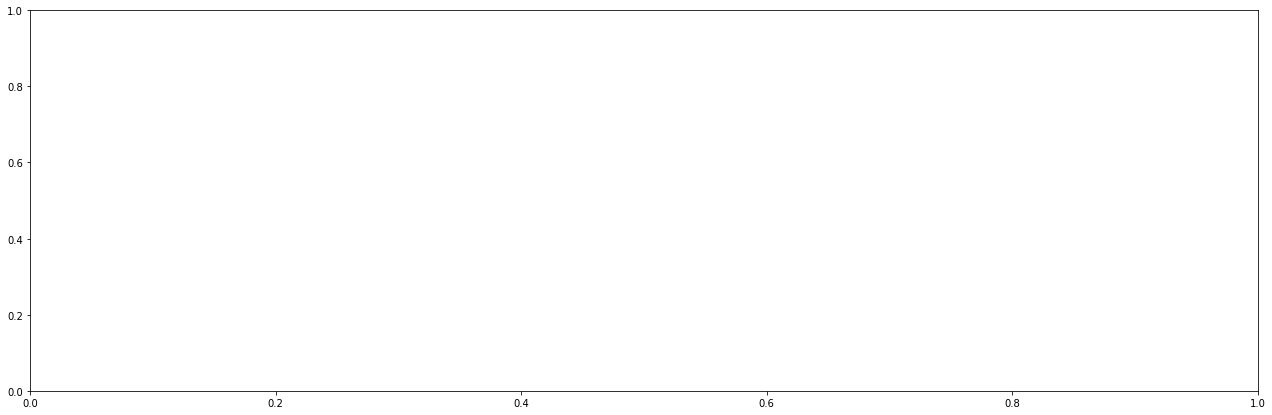

In [32]:
#Confusion Matrix

from sklearn.metrics import confusion_matrix
import itertools
plt.subplots(figsize=(22,7)) #set the size of the plot 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

# Visualize Predictions

In [33]:
Predicted_classes = model.predict_classes(X_test)

NameError: name 'model' is not defined

In [34]:
wrong_preds = X_test[Predicted_classes != np.argmax(y_test)]

NameError: name 'Predicted_classes' is not defined

In [35]:
set(Predicted_classes)

NameError: name 'Predicted_classes' is not defined

In [36]:
i = 10

In [37]:
pred = model.predict_classes(np.array([wrong_preds[i]]))[0]
act = np.argmax(y_test[i])
print("Predicted class: {}".format(enc.classes_[pred]))
print("Actual class: {}".format(enc.classes_[act]))

plt.imshow(wrong_preds[i])

NameError: name 'model' is not defined

In [38]:
enc.inverse_transform(np.array([y_test[10]]))

array(['Sugar beet'], dtype='<U25')

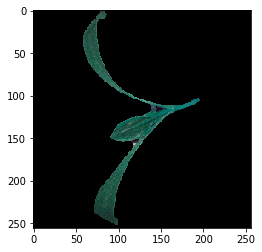

In [39]:
plt.imshow(X_test[10])

In [40]:
enc.classes_

array(['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed',
       'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize',
       'Scentless Mayweed', 'Shepherds Purse',
       'Small-flowered Cranesbill', 'Sugar beet'], dtype='<U25')